TP ESPECIAL FUNDAMENTOS DE LA CIENCIA DE DATOS 2024 

DATASET: CALIDAD DE AGUA DEL RÍO DE LA PLATA - 2022

INTEGRANTES:
Abril Valentina Valentina Juarez, Matias Müller Gonzales y Julián Elias Rivero

In [3]:
# corroborar si funciona con % o con !

%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install fancyimpute
%pip install scikit-learn
%pip install scipy
%pip install seaborn

# importar librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer,KNN
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import seaborn as sns



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: fancyimpute in c:\users\matias\desktop\tp especial - ciencia de datos\practicoespecialvenv\lib\site-packages (0.7.0)




[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
raw_dataset = pd.read_csv("Calidad_de_agua_2022.csv", sep =";")

Desplegamos el dataset para realizar un vistazo generico

In [5]:
#pd.reset_option('display.max_rows') - 
# descomentar lo de arriba si quiere que le muestre el dataset truncado!!!!
raw_dataset

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,23/2/2022,2022,Verano,24.5,23.3,5.3,6.56,...,6.2,29,90,<0.10,<0.005,<0.001,<10,<0.20,55,Muy deteriorada
1,2,Río Lujan y Arroyo Caraguatá,TI006,23/2/2022,2022,Verano,25.4,23.3,2.25,6.56,...,5.8,29,34,<0.10,<0.005,<0.001,<10,<0.20,42,Extremadamente deteriorada
2,3,Canal Aliviador y Río Lujan,TI002,23/2/2022,2022,Verano,24.6,23.3,2.94,6.59,...,1.9,29,17,<0.10,<0.005,<0.001,<10,0.2,45,Muy deteriorada
3,4,Río Carapachay y Arroyo Gallo Fiambre,TI003,23/2/2022,2022,Verano,25.2,23.3,2.22,7.45,...,5.8,29,23,<0.10,<0.005,<0.001,<10,<0.20,46,Muy deteriorada
4,5,Río Reconquista y Río Lujan,TI004,23/2/2022,2022,Verano,24.1,20,1.02,6.39,...,2.6,59,18,<0.10,<0.005,<0.001,<10,<0.20,44,Extremadamente deteriorada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,38,Balneario Palo Blanco,BS092,31/10/2022,2022,Primavera,10,12,no se midió,no se midió,...,no se midió,<30,23,<0.10,<0.005,<0.001,2.1,<0.15,43,Extremadamente deteriorada
164,39,Diagonal 66 (descarga cloaca),BS095,31/10/2022,2022,Primavera,10,12,no se midió,no se midió,...,no se midió,31,18.2,<0.10,<0.005,<0.001,20.2,<0.15,37,Extremadamente deteriorada
165,40,Playa La Bagliardi,BS091,31/10/2022,2022,Primavera,10,12,no se midió,no se midió,...,no se midió,<30,40,<0.10,<0.005,<0.001,0.2,<0.15,49,Muy deteriorada
166,41,Balneario Municipal,BS094,31/10/2022,2022,Primavera,10,12,no se midió,no se midió,...,no se midió,39,90,<0.10,5,<0.001,10.5,<0.15,39,Extremadamente deteriorada


Ahora le pedimos un poco de informacion para analizar contexto de los datos

In [6]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   orden                    168 non-null    int64 
 1   sitios                   168 non-null    object
 2   codigo                   168 non-null    object
 3   fecha                    168 non-null    object
 4   año                      168 non-null    object
 5   campaña                  168 non-null    object
 6   tem_agua                 168 non-null    object
 7   tem_aire                 166 non-null    object
 8   od                       168 non-null    object
 9   ph                       168 non-null    object
 10  olores                   168 non-null    object
 11  color                    168 non-null    object
 12  espumas                  168 non-null    object
 13  mat_susp                 168 non-null    object
 14  colif_fecales_ufc_100ml  167 non-null    o

En total tenemos 31 columnas (atributos) y 168 filas (observaciones). Se puede ver que hay ciertas columnas con NULL y que el tipo de datos practicamente es OBJECT exceptuando la primer columna "orden" que es de tipo INT64.

In [7]:
raw_dataset.head()

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,23/2/2022,2022,Verano,24.5,23.3,5.3,6.56,...,6.2,29,90,<0.10,<0.005,<0.001,<10,<0.20,55,Muy deteriorada
1,2,Río Lujan y Arroyo Caraguatá,TI006,23/2/2022,2022,Verano,25.4,23.3,2.25,6.56,...,5.8,29,34,<0.10,<0.005,<0.001,<10,<0.20,42,Extremadamente deteriorada
2,3,Canal Aliviador y Río Lujan,TI002,23/2/2022,2022,Verano,24.6,23.3,2.94,6.59,...,1.9,29,17,<0.10,<0.005,<0.001,<10,0.2,45,Muy deteriorada
3,4,Río Carapachay y Arroyo Gallo Fiambre,TI003,23/2/2022,2022,Verano,25.2,23.3,2.22,7.45,...,5.8,29,23,<0.10,<0.005,<0.001,<10,<0.20,46,Muy deteriorada
4,5,Río Reconquista y Río Lujan,TI004,23/2/2022,2022,Verano,24.1,20,1.02,6.39,...,2.6,59,18,<0.10,<0.005,<0.001,<10,<0.20,44,Extremadamente deteriorada


A simple vista veo que tendremos que tratar lo siguiente:
1) Hay valores que enves de tener un tipo de dato cuantitativo en el atributo, tienen un string categorico que dice "no se midio" o variantes del mismo, por ejemplo en OD(oxigeno disuelto), esto deberia de ser reemplazado NA.
2) Hay datos cuantitativos que adelante del valor numerico tienen un string "<", como en el caso de las mediciones de los contaminantes en el agua.
Podriamos generar un mapa que descriva las observaciones de dicha variable. 
3) Hay datos cualitativos nominales que indican "presencia" o "ausencia" de algún compuesto en el agua, estás variables son dicotomicas, seran reemplazados por {0, 1} de acuerdo a su impacto en la muestra. 
4) Hay datos cualitativos ordinales como "muy deteriorada" o "extremadamente deteriorada" que hacen referencia al agua de esa zona, seran reemplazados mediante transformacion "ordinal encoding" ya que el orden es significativo.

Veamos cuantos valores repetidos tiene el dataset

In [8]:
raw_dataset.duplicated().sum()

np.int64(0)

Por lo visto no existe valores repetidos a simple vista.

Ya que empezaremos a modificar el dataset, una buena practica es copiar el dataset

In [9]:
copy_dataset = raw_dataset.copy()

podemos eliminar columnas que no tienen mucho sentido, como por ejemplo "orden" y vamos a eliminar "año", ya que todas las observaciones se hicieron en 2022 y no agregan mucha informacion

In [10]:
copy_dataset = copy_dataset.drop("orden",axis=1)
copy_dataset = copy_dataset.drop("año",axis=1)

Ahora vamos a ver que columnas tienen nulos

In [11]:
copy_dataset.isna().sum()

sitios                      0
codigo                      0
fecha                       0
campaña                     0
tem_agua                    0
tem_aire                    2
od                          0
ph                          0
olores                      0
color                       0
espumas                     0
mat_susp                    0
colif_fecales_ufc_100ml     1
escher_coli_ufc_100ml       1
enteroc_ufc_100ml           1
nitrato_mg_l                0
nh4_mg_l                    0
p_total_l_mg_l              0
fosf_ortofos_mg_l           0
dbo_mg_l                    1
dqo_mg_l                    0
turbiedad_ntu               0
hidr_deriv_petr_ug_l        0
cr_total_mg_l               0
cd_total_mg_l               0
clorofila_a_ug_l            1
microcistina_ug_l           0
ica                        13
calidad_de_agua            14
dtype: int64

Pareciera que existen muy pocos nulos, pero vamos a ver que sucede con el "no se midió" , asi que vamos a mostrar algunos ejemplos

In [12]:
copy_dataset[copy_dataset["dbo_mg_l"] == "no se midió"].head()

,sitios,codigo,fecha,campaña,tem_agua,tem_aire,od,ph,olores,color,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
10,Espigón La Farola,SI021,23/2/2022,Verano,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,...,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,NaN,NaN
12,Playa Espigón de Pacheco,SI024,23/2/2022,Verano,26.5,27,5.3,7.49,Ausencia,Ausencia,...,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,NaN,NaN
17,Parque de los Niños,CA041,23/2/2022,Verano,26.1,no se midió,4.8,7.4,Ausencia,Ausencia,...,no se midió,29,22,no se midió,<0.005,<0.002,no se midió,no se midió,54,Muy deteriorada
27,Náutico 400 m,QU062,23/2/2022,Verano,24,23,9.59,7.94,Ausencia,Ausencia,...,no se midió,29,26,<0.10,<0.005,<0.001,28,1,48,Muy deteriorada
30,Puerto Trinidad calle 47,BZ077,23/2/2022,Verano,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,...,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,no se midió,NaN,NaN


Como pudimos ver hay muchisimos "no se midió" que representa NA, entonces vamos a convertir para todas las columnas
el "no se midió" y las distintas variantes a NA

In [13]:
lista_columnas = copy_dataset.columns

for col in lista_columnas:
    copy_dataset[col] = copy_dataset[col].replace(['no midieron este día', 'no se midió', 'no se determinó','No se midió',
                                                   'no midio la sonda','NA'], pd.NA)

Una vez pasado todos los valores a NA vamos a contar cuantos NA tenemos por cada variable

In [14]:
copy_dataset.isna().sum()

sitios                      0
codigo                      0
fecha                       5
campaña                     5
tem_agua                   23
tem_aire                   24
od                         36
ph                         28
olores                     13
color                      13
espumas                    13
mat_susp                   13
colif_fecales_ufc_100ml    15
escher_coli_ufc_100ml      15
enteroc_ufc_100ml          15
nitrato_mg_l               14
nh4_mg_l                   14
p_total_l_mg_l             21
fosf_ortofos_mg_l          14
dbo_mg_l                   58
dqo_mg_l                   14
turbiedad_ntu              14
hidr_deriv_petr_ug_l       18
cr_total_mg_l              17
cd_total_mg_l              17
clorofila_a_ug_l           18
microcistina_ug_l          18
ica                        14
calidad_de_agua            14
dtype: int64

In [15]:
copy_dataset.isna().sum() / copy_dataset.shape[0]

sitios                     0.000000
codigo                     0.000000
fecha                      0.029762
campaña                    0.029762
tem_agua                   0.136905
tem_aire                   0.142857
od                         0.214286
ph                         0.166667
olores                     0.077381
color                      0.077381
espumas                    0.077381
mat_susp                   0.077381
colif_fecales_ufc_100ml    0.089286
escher_coli_ufc_100ml      0.089286
enteroc_ufc_100ml          0.089286
nitrato_mg_l               0.083333
nh4_mg_l                   0.083333
p_total_l_mg_l             0.125000
fosf_ortofos_mg_l          0.083333
dbo_mg_l                   0.345238
dqo_mg_l                   0.083333
turbiedad_ntu              0.083333
hidr_deriv_petr_ug_l       0.107143
cr_total_mg_l              0.101190
cd_total_mg_l              0.101190
clorofila_a_ug_l           0.107143
microcistina_ug_l          0.107143
ica                        0

Además vemos que ninguna variable tiene más del 50% de valores faltantes, por ende no eliminaremos ninguna variable 

Se eliminaran todas aquellas observaciones que contengan 14 o mas atributos con valores NA, ya que no nos aportara mucha informacion

In [16]:
copy_dataset = copy_dataset.dropna(thresh=14)

A continuacion estamos mostrando aquellas observaciones donde en la columna microcistina_ug_l se encuentran valores que deberian ser numericos, pero son de tipo object, porque hay texto combinado con numeros. Observamos que hay esto sucede en reiteradas ocasiones.

In [17]:
copy_dataset[copy_dataset["microcistina_ug_l"] == " <0.15"].value_counts()

sitios                                 codigo  fecha      campaña   tem_agua  tem_aire  od     ph    olores     color      espumas   mat_susp   colif_fecales_ufc_100ml  escher_coli_ufc_100ml  enteroc_ufc_100ml  nitrato_mg_l  nh4_mg_l  p_total_l_mg_l  fosf_ortofos_mg_l  dbo_mg_l  dqo_mg_l  turbiedad_ntu  hidr_deriv_petr_ug_l  cr_total_mg_l  cd_total_mg_l  clorofila_a_ug_l  microcistina_ug_l  ica  calidad_de_agua           
Arroyo Abra Vieja y Santa Rosa         TI009   23/8/2022  invierno  15.6      15        8.68   7.13  Ausencia   Ausencia   Ausencia  Ausencia   3200                     2                      250                2.4           0.11      0.12            0.12               <2.0      <30       33              <0.10                <0.005         <0.001         200                <0.15             51   Muy deteriorada               1
Arroyo El Gato                         EN083   23/8/2022  invierno  12.8      9         2.49   8.01  Ausencia   Ausencia   Ausencia  Ausencia  

Para las siguientes columnas fue necesario quitar el string "<" y " <"(este caracter es el denominado NBSP)

In [18]:
columnas = [
    "nh4_mg_l",
    "p_total_l_mg_l",
    "fosf_ortofos_mg_l",
    "dbo_mg_l",
    "dqo_mg_l",
    "turbiedad_ntu",
    "hidr_deriv_petr_ug_l",
    "cr_total_mg_l",
    "cd_total_mg_l",
    "clorofila_a_ug_l",
    "microcistina_ug_l"
]
for col in columnas:
    copy_dataset[col] = copy_dataset[col].str.strip("<")
    copy_dataset[col] = copy_dataset[col].str.strip(" <")

Ahora veamos la variable "cd_total_mg_l" y notaremos que a pesar de quitar el "<" el tipo de dato no cambio, sigue siendo de tipo object

In [19]:
copy_dataset[copy_dataset["cd_total_mg_l"] == "0.001"].value_counts()

sitios                          codigo  fecha      campaña   tem_agua  tem_aire  od    ph    olores     color     espumas   mat_susp   colif_fecales_ufc_100ml  escher_coli_ufc_100ml  enteroc_ufc_100ml  nitrato_mg_l  nh4_mg_l  p_total_l_mg_l  fosf_ortofos_mg_l  dbo_mg_l  dqo_mg_l  turbiedad_ntu  hidr_deriv_petr_ug_l  cr_total_mg_l  cd_total_mg_l  clorofila_a_ug_l  microcistina_ug_l  ica  calidad_de_agua           
Arroyo Abra Vieja y Santa Rosa  TI009   23/2/2022  Verano    23.4      21        4.49  6.76  Ausencia   Ausencia  Ausencia  Ausencia   400                      100                    220                1.9           0.1       0.21            0.19               1.9       29        39             0.10                  0.005          0.001          10                0.20               58   Muy deteriorada               1
                                        23/8/2022  invierno  15.6      15        8.68  7.13  Ausencia   Ausencia  Ausencia  Ausencia   3200                     2

Entonces para esta variable en particular vamos a realizar un mapeo para sustituir el tipo string a tipo entero

In [20]:
mgl_map = {
    "0.001":0.001,
    "0.002":0.002
}
copy_dataset["cd_total_mg_l"] = copy_dataset["cd_total_mg_l"].map(mgl_map)
copy_dataset["cd_total_mg_l"].info()

<class 'pandas.core.series.Series'>
Index: 154 entries, 0 to 167
Series name: cd_total_mg_l
Non-Null Count  Dtype  
--------------  -----  
151 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


Para la variable calidad_de_agua hicimos una transformacion ordinal encoding, donde cada valor unico de una caracteristica se mapea a un entero, tratando de ser lo mas cuidadoso para preservar el orden natural

In [21]:
niveles_deterioro = {
    "Deteriorada" : 1,
    "Muy deteriorada" : 2,
    "Extremadamente deteriorada" : 3
}

copy_dataset["calidad_de_agua"] = copy_dataset["calidad_de_agua"].map(niveles_deterioro)

Para las siguientes variables continuaremos con un tipo de mapeo dicotomico

In [22]:
mapeo_dicotomico = {
    "Ausencia" : 0,
    "Ausente" : 0,
    "ausencia" : 0,
    "presencia" : 1,
    "Presencia" : 1
}

copy_dataset["olores"] = copy_dataset["olores"].map(mapeo_dicotomico)
copy_dataset["color"] = copy_dataset["color"].map(mapeo_dicotomico)
copy_dataset["espumas"] = copy_dataset["espumas"].map(mapeo_dicotomico)
copy_dataset["mat_susp"] = copy_dataset["mat_susp"].map(mapeo_dicotomico)

A continuacion vamos a cambiar dos valores de la variable "fecha", ya que la fecha de la medicion se cargo como "31/10/0202" cuando en realidad intumos que se quiso cargar "31/10/2022" debido a que todas las muestras fueron realizadas en dicho año

In [23]:
copy_dataset["fecha"] = copy_dataset["fecha"].replace("31/10/0202", "31/10/2022")
copy_dataset["fecha"].value_counts()

fecha
4/5/2022      41
23/2/2022     39
23/8/2022     37
31/10/2022    37
Name: count, dtype: int64

Para tratar los NA vamos a operar con todas las columnas que lo posean, a traves de una serie de pasos
1_Convertir todas las variables a tipo numerico, exceptuando los NA(aquellos que no puedan convertirse, como los NA, seran convertidos a NAN)
2_Calcularemos la mediana para cada estacion del año
3_Con la funcion fillna, Asignaremos la mediana de cada estacion a los valores NAN en funcion de la columna a la que pertenezca

Decidimos hacer imputacion por mediana y por estacion, para mantener la distribucion de los datos lo mas equilibrada posible.

In [24]:
columnas = [
    "tem_agua",
    "tem_aire",
    "od",
    "ph",
    "colif_fecales_ufc_100ml",
    "escher_coli_ufc_100ml",
    "enteroc_ufc_100ml",
    "nitrato_mg_l",
    "nh4_mg_l",
    "p_total_l_mg_l",
    "fosf_ortofos_mg_l",
    "dbo_mg_l",
    "dqo_mg_l",
    "turbiedad_ntu",
    "hidr_deriv_petr_ug_l",
    "cr_total_mg_l",
    "cd_total_mg_l",
    "clorofila_a_ug_l",
    "microcistina_ug_l",
    "ica"
]
for col in columnas:
    copy_dataset[col] = pd.to_numeric(copy_dataset[col], errors= 'coerce')
    
    median_verano = copy_dataset.loc[copy_dataset["campaña"] == "Verano", col].median()
    median_invierno = copy_dataset.loc[copy_dataset["campaña"] == "invierno", col].median()
    median_otoño = copy_dataset.loc[copy_dataset["campaña"] == "otoño", col].median()
    median_primavera = copy_dataset.loc[copy_dataset["campaña"] == "Primavera", col].median()
    
    copy_dataset.loc[(copy_dataset['campaña'] == 'Verano') & (copy_dataset[col].isna()), col] = median_verano
    copy_dataset.loc[(copy_dataset['campaña'] == 'invierno') & (copy_dataset[col].isna()), col] = median_invierno
    copy_dataset.loc[(copy_dataset['campaña'] == 'Primavera') & (copy_dataset[col].isna()), col] = median_primavera
    copy_dataset.loc[(copy_dataset['campaña'] == 'otoño') & (copy_dataset[col].isna()), col]=median_otoño

c:\Users\Matias\Desktop\TP ESPECIAL - CIENCIA DE DATOS\practicoespecialvenv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Vemos que devolvio una advertencia, lo que indica que para alguna columna no pudo calcular la mediana. indagamos un poco mas y es la columna "dbo_mg_l"

In [25]:
#Filtramos las muestras donde la campaña es primavera y la columna "dbo_mg_l" = Nan
primavera_nan = copy_dataset[(copy_dataset['campaña'] == 'Primavera') & (copy_dataset['dbo_mg_l'].isna())]
print(primavera_nan)

                                    sitios    codigo       fecha    campaña  \
126           Canal Villanueva y Río Luján     TI001  31/10/2022  Primavera   
127           Río Lujan y Arroyo Caraguatá     TI006  31/10/2022  Primavera   
128            Canal Aliviador y Río Lujan     TI002  31/10/2022  Primavera   
129  Río Carapachay y Arroyo Gallo Fiambre     TI003  31/10/2022  Primavera   
130            Río Reconquista y Río Lujan     TI004  31/10/2022  Primavera   
131     Rio Tigre 100m antes del Rio Luján     TI005  31/10/2022  Primavera   
132         Río Lujan y Canal San Fernando     TI007  31/10/2022  Primavera   
133          Río Capitán y Río San Antonio     TI008  31/10/2022  Primavera   
134         Arroyo Abra Vieja y Santa Rosa     TI009  31/10/2022  Primavera   
135                               Del Arca     SF015  31/10/2022  Primavera   
137                      Reserva Ecológica     SI022  31/10/2022  Primavera   
138               Playa Espigón de Pacheco     SI024

Observamos que para la columna "dbo_mg_l" para la campaña Primavera siguen habiendo ocurrencias Nan.
la mediana devuelve NaN, significa que no hay suficientes datos válidos en la campaña "Primavera" para calcular una mediana, y eso explicaría por qué no podemos reemplazar los valores NaN. En ese caso, podríamos intentar un enfoque alternativo, como usar un valor por defecto o una mediana calculada de otra campaña.

In [26]:
# Calcular la mediana total de la columna 'dbo_mg_l' sin filtrar por campaña
median_total = copy_dataset['dbo_mg_l'].median()
# Reemplazar los valores NaN en 'dbo_mg_l' para la campaña 'Primavera' con la mediana total
copy_dataset.loc[(copy_dataset['campaña'] == 'Primavera') & (copy_dataset['dbo_mg_l'].isna()), 'dbo_mg_l'] = median_total


verificamos que se reemplazaron los Nan correctamente

In [27]:
copy_dataset["dbo_mg_l"]

0      6.2
1      5.8
2      1.9
3      5.8
4      2.6
      ... 
163    5.0
164    5.0
165    5.0
166    5.0
167    5.0
Name: dbo_mg_l, Length: 154, dtype: float64

Ahora si estamos en condiciones!

Realizamos un describe para ver una serie de caracteristicas descriptivas

In [28]:
#seteamos la opcion para que el dataset muestre los valores completos y no en notacion cientifica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [29]:
# Ajustes para que se muestren todas las filas y columnas sin truncamiento
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [30]:
copy_dataset.describe()

,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
count,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000,154.000
mean,17.900,15.826,6.777,7.439,0.078,0.084,0.032,0.175,86140.292,4068.110,947.831,6.869,1.941,0.863,0.415,5.875,44.188,34.762,0.101,0.544,0.001,263.861,0.189,44.071,2.584
std,4.786,5.023,2.642,0.697,0.269,0.279,0.178,0.381,380084.458,15012.075,2999.021,4.043,4.120,3.386,0.309,4.571,23.477,23.854,0.008,1.946,0.000,816.715,0.159,8.949,0.520
min,6.000,4.000,0.360,5.000,0.000,0.000,0.000,0.000,80.000,1.000,2.000,1.900,0.049,0.100,0.100,1.900,29.000,2.500,0.100,0.005,0.001,0.000,0.150,23.000,1.000
25%,14.933,13.000,5.363,7.000,0.000,0.000,0.000,0.000,1200.000,100.000,57.500,3.700,0.103,0.270,0.230,3.625,30.000,18.050,0.100,0.005,0.001,10.000,0.150,38.000,2.000
50%,17.850,14.000,6.805,7.355,0.000,0.000,0.000,0.000,3900.000,330.000,300.000,5.850,0.650,0.370,0.330,5.000,30.000,27.500,0.100,0.005,0.001,10.000,0.150,42.000,3.000
75%,20.775,19.000,8.170,7.790,0.000,0.000,0.000,0.000,37500.000,1675.000,667.500,8.800,1.675,0.565,0.497,6.425,52.250,45.000,0.100,0.005,0.001,41.800,0.200,50.000,3.000
max,27.400,27.000,17.610,10.020,1.000,1.000,1.000,1.000,4200000.000,150000.000,28000.000,21.900,23.000,30.120,2.600,42.000,180.000,130.000,0.200,12.000,0.002,6410.000,1.670,76.000,3.000


Okey, vemos ciertas conductas en algunos indicadores:
- en el maximo valor de "Colif_fecales_ufc_100ml" (es absurdamente grande) siendo que hasta el 3er cuartil no acumula siquiera la mitad del maximo
- en "Fósforo total" o "p_total_l_mg_l" cuyo valor maximo es de 30.120 mg/L
- "Oxigeno Disuelto" tiene un minimo bastante chico, y un maximo bastante grande, entre los cuartiles no varia tanto
- olores, color, espumas y materia suspendia, fueron mapeadas por lo que no aportan mucho, podemos deducir que en la mayoria de los casos no estan presentes en el agua porque el promedio de cada una esta por debajo del 17%
- en "nh4_mg_l" o "Concentración de amonio"se observa un maximo muy superior a los demas valores
- tanto en DBO como en DQO, sus maximos son mas grandes que el valor acumulado hasta el 3er cuartil
- La turbiedad en promedio es 34.762 NTU, mientras que el minimo es de 2.5 NTU y el maximo de 130 NTU (bastante turbio jajaj)
- La "Concentración total de cromo" es bastante baja en promedio, pero el maximo esta muy alejado
- La "Concentración de clorofila" tiene un desvio estandar muy grande ya que el maximo esta muy alejado

Conforme vayamos avanzando, veremos en cuales indicadores deberemos de tomar alguna decision al respecto, si sacar los outliers o darles sentido, acorde a si son un posible error de muestreo, o tienen relevancia en la zona donde se extrajo esa muestra

Para empezar nuestro analisis tecnico, nos centraremos en principio en el ICA (Indice de Calidad del Agua) ya que es una medida utilizada para evaluar la calidad general del agua de manera sencilla, basándose en varios parámetros como la concentración de contaminantes, la turbidez, la oxigenación, el pH, entre otros

Veamos en el siguiente histograma, como se distribuyen los diferentes valores del ICA en todas las observaciones

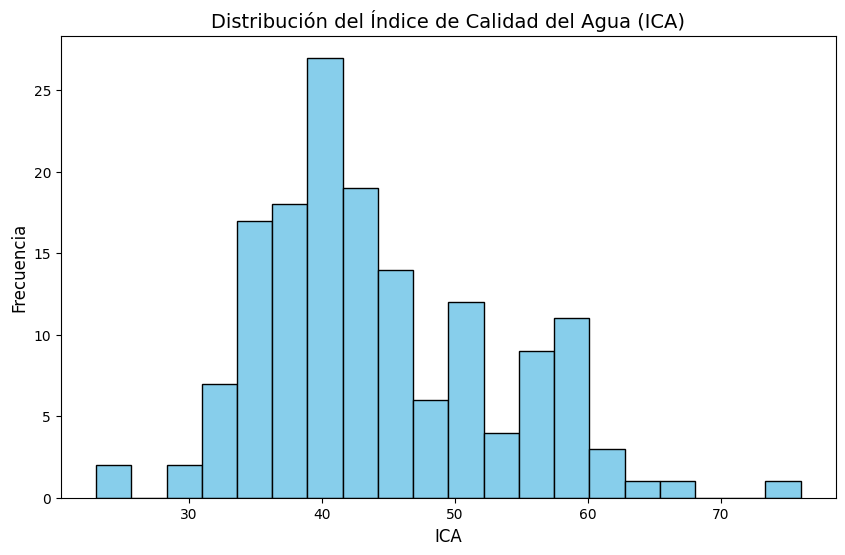

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(copy_dataset['ica'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución del Índice de Calidad del Agua (ICA)', fontsize=14)
plt.xlabel('ICA', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

En el grafico vemos que los valores que mas se repiten de ICA oscilan entre 35 y 45 (siendo 40 el que mas se repite) lo que indicaria una prevalencia de media a baja calidad de agua. Tambien se observa que hay 2 valores que se alejan bastante de los demas, uno mayor a 70 y el otro menor a 30.

En principio, uno pensaria que el ICA deberia de ser peor en condiciones climaticas de mayor temperatura, osea valores mas bajos, ya que la temperatura del agua se eleva y trae consigo ciertos fenomenos como la elevacion de los niveles de contaminantes orgánicos, la reduccion de la cantidad de oxígeno disuelto en el agua o incluso el aumento de los niveles de clorofila, afectando los valores de turbidez.

Esto podria ser tomado como una primera hipotesis inicial, en la que comprobaremos si el ICA en Verano, es peor que en las otras estaciones, debido al aumento de precipitaciones, humedad, mas calor, etc. ¿Sera asi?

Examinaremos los valores del ICA para las 4 campañas o fechas del dataset, que corresponden a las 4 estaciones del año: Verano, Otoño, Invierno y Primavera

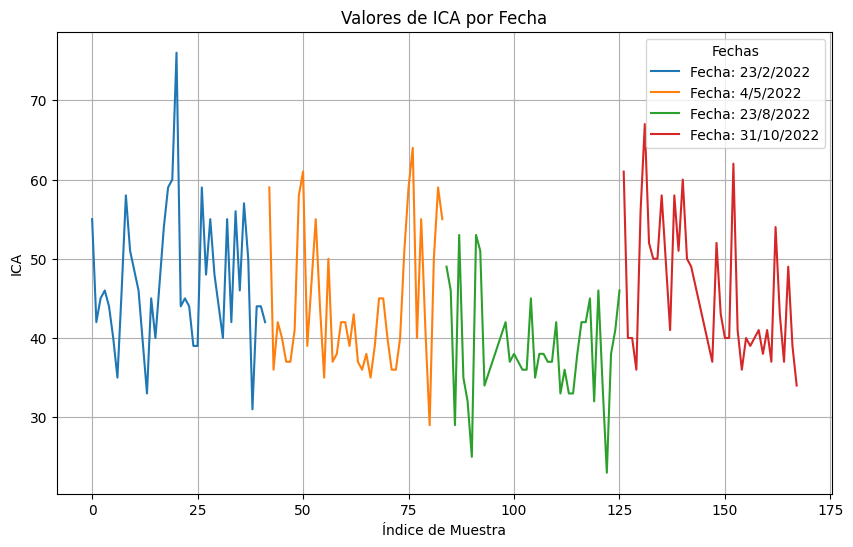

In [32]:
plt.figure(figsize=(10, 6))
# iteracion donde por cada una de las 4 fechas de muestreo, muestra la variacion del ICA
for fecha in copy_dataset['fecha'].unique():
    data_fecha = copy_dataset[copy_dataset['fecha'] == fecha]
    plt.plot(data_fecha['ica'], label=f'Fecha: {fecha}')

plt.xlabel('Índice de Muestra')
plt.ylabel('ICA')
plt.grid(True)
plt.legend(title='Fechas')
plt.title('Valores de ICA por Fecha')
plt.show()

Podemos observar, que hay una tendencia de menores niveles de ICA en la campaña "Invierno" (23/08/2022). Los 3 valores mas chicos que toma este indicador, estan presentes en esta estacion por alguna razon, lo que parece extraño, porque en inicio creiamos lo opuesto. Ademas en verano vemos un pico bastante alto que podria ser un error de medicion o alguna zona en la que raramente ese valor es muy alto.

In [33]:
# Ajustes para que se muestren todas las filas y columnas sin truncamiento
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

LA SIGUIENTE FUNCION, OPERA POR CADA OBSERVACION DEL DATASET, AGREGANDO A LA LISTA "INDICES_FILTRADOS" AQUELLAS MUESTRAS HECHAS EN INVIERNO DONDE EL "ICA" SEA MENOR EN COMPARACION CON LAS OTRAS 3 CAMPAÑAS, PARA ESA MISMA OBSERVACION.

In [34]:
def filtrar_ica_minimo(df):
    # Inicializar una lista para guardar los índices de las filas que cumplen la condición
    indices_filtrados = []
    
    # Iterar sobre las filas de la campaña "invierno"
    for idx, row in df[df['campaña'] == 'invierno'].iterrows():
        # Obtener el valor de ICA para la fila actual
        ica_invierno = row['ica']
        
        # Filtrar las filas con la misma observación en otras campañas
        otras_campañas = df[(df['sitios'] == row['sitios']) & (df['campaña'] != 'invierno')]
        
        # Obtener el valor mínimo de ICA de las otras campañas
        min_ica_otra_campaña = otras_campañas['ica'].min()
        
        # Si el ICA en invierno es menor que el mínimo de las otras campañas, agregar el índice a la lista
        if ica_invierno < min_ica_otra_campaña:
            indices_filtrados.append(idx)
    
    # Devolver el indice de las filas filtradas
    return indices_filtrados

# Llamar a la función con la copia del dataset
resultado = filtrar_ica_minimo(copy_dataset)

print(resultado)

[84, 86, 88, 89, 90, 93, 98, 102, 103, 105, 109, 110, 111, 113, 114, 115, 119, 120, 121, 122, 123]


VEMOS QUE 21 de 37 muestras totales hechas en invierno, el "ICA" es mas bajo en comparacion a las demas estaciones. un 56% lo que es bastante peculiar

Procederemos a ver en que sitios el ICA es mas bajo para la campaña invierno

In [35]:
copy_dataset[copy_dataset['campaña'] == 'invierno'].nsmallest(5, 'ica')

,sitios,codigo,fecha,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
122,Diagonal 66 (descarga cloaca),BS095,23/8/2022,invierno,11.000,14.000,8.050,8.130,1,1,1,1,700000.000,440.000,30.000,2.100,19.000,1.400,1.400,21.000,30,11.000,0.100,0.005,0.001,630.000,0.150,23,3
90,Río Lujan y Canal San Fernando,TI007,23/8/2022,invierno,16.500,15.000,1.130,7.120,1,1,0,0,240000.000,90.000,9.000,11.700,9.300,0.860,0.860,14.000,30,20.500,0.100,5.000,0.001,10.000,0.150,25,3
86,Canal Aliviador y Río Lujan,TI002,23/8/2022,invierno,14.400,14.000,0.450,7.140,1,0,0,0,4200000.000,186.000,11.000,11.700,23.000,2.800,2.600,42.000,75,13.000,0.100,0.009,0.001,10.000,0.150,29,3
89,Rio Tigre 100m antes del Rio Luján,TI005,23/8/2022,invierno,14.300,13.000,0.360,6.880,0,0,0,1,1070000.000,560.000,27.000,2.000,22.000,1.900,0.280,2.000,30,33.000,0.200,0.011,0.001,10.000,0.150,32,3
119,Arroyo El Gato,EN083,23/8/2022,invierno,12.800,9.000,2.490,8.010,0,0,0,0,192000.000,60.000,24.000,2.000,22.000,1.200,1.200,18.000,30,20.500,0.100,0.005,0.001,1960.000,0.150,32,3


- El ICA oscila entre 23 y 32, lo que es muy bajo.
- En todas la calidad del agua esta extremadamente deteriorada.
- En las primeras 2 observaciones hay presencia de olores y colores en el agua.
- La turbidez en todos los casos es mayor a 11, lo que es un peligroso para la salud.
- Para la 2da observacion la concentracion total de cromo es elevadisima.

Examinemos el sitio para el cual el ICA es mas bajo, "Diagonal 66 (descarga cloaca)", para las 4 campañas diferentes

In [36]:
#buscamos las 4 observaciones del mismo sitio
copy_dataset[copy_dataset['sitios'] == 'Diagonal 66 (descarga cloaca)']

,sitios,codigo,fecha,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
38,Diagonal 66 (descarga cloaca),BS095,23/2/2022,Verano,20.000,18.000,6.560,8.110,1,1,1,1,150000.000,2800.000,20000.000,2.000,0.049,1.500,1.300,8.400,29,4.100,0.100,0.005,0.001,10.000,0.200,31,3
80,Diagonal 66 (descarga cloaca),BS095,4/5/2022,otoño,8.000,12.000,7.200,7.990,1,1,1,1,400000.000,150000.000,28000.000,8.100,8.500,1.200,0.850,7.100,66,3.300,0.100,0.005,0.001,10.000,0.150,29,3
122,Diagonal 66 (descarga cloaca),BS095,23/8/2022,invierno,11.000,14.000,8.050,8.130,1,1,1,1,700000.000,440.000,30.000,2.100,19.000,1.400,1.400,21.000,30,11.000,0.100,0.005,0.001,630.000,0.150,23,3
164,Diagonal 66 (descarga cloaca),BS095,31/10/2022,Primavera,10.000,12.000,7.210,7.000,0,1,0,1,80000.000,80000.000,12000.000,5.200,1.200,30.120,0.390,5.000,31,18.200,0.100,0.005,0.001,20.200,0.150,37,3


Para las 4 campañas, el valor mas bajo de ICA para este lugar en concreto, es en invierno. Veremos que atributos son los mas impactantes para esta campaña a ver si podemos deducir algo.
Se ve que es un lugar bastante contaminado ya que cuenta con la presencia de olor, color, espuma y materia suspendida en el agua, pero ¿Por que el ICA nos da mas bajo en invierno¿ ¿Sera que en esta estacion ocurre algo en la zona que provoca esta anomalia? de verificar esto, no olvidar que 21 de 37 muestras dieron un indice de calidad de agua menor en invierno que en las otras estaciones, un 56%, lo que probablemente signifique que pueda haber una relacion entre el ICA y las temperaturas mas bajas, para este dataset

Verificaremos si hay una relacion entre las temperaturas y el ICA.
Cálculo del p-valor para las correlaciones entre "tem_agua" y "ICA", y entre "tem_aire" y "ICA":

In [37]:
# Normalizamos mediante el metodo MIN-MAX
copy_dataset['tem_agua_norm'] = (copy_dataset['tem_agua'] - copy_dataset['tem_agua'].min()) / (copy_dataset['tem_agua'].max() - copy_dataset['tem_agua'].min())
copy_dataset['tem_aire_norm'] = (copy_dataset['tem_aire'] - copy_dataset['tem_aire'].min()) / (copy_dataset['tem_aire'].max() - copy_dataset['tem_aire'].min())
copy_dataset['ica_norm'] = (copy_dataset['ica'] - copy_dataset['ica'].min()) / (copy_dataset['ica'].max() - copy_dataset['ica'].min())

# Correlación y p-valor entre "tem_agua" y "ICA"
corr_tem_agua_ica, p_val_agua_ica = pearsonr(copy_dataset['tem_agua_norm'], copy_dataset['ica_norm'])
print(f"Correlación entre Temperatura del Agua y ICA: {corr_tem_agua_ica}")
print(f"P-valor entre Temperatura del Agua y ICA: {p_val_agua_ica}")

# Correlación y p-valor entre "tem_aire" y "ICA"
corr_tem_aire_ica, p_val_aire_ica = pearsonr(copy_dataset['tem_aire_norm'], copy_dataset['ica_norm'])
print(f"Correlación entre Temperatura del Aire y ICA: {corr_tem_aire_ica}")
print(f"P-valor entre Temperatura del Aire y ICA: {p_val_aire_ica}")

Correlación entre Temperatura del Agua y ICA: 0.2714883695794689
P-valor entre Temperatura del Agua y ICA: 0.0006596309209046694
Correlación entre Temperatura del Aire y ICA: 0.12390020666894705
P-valor entre Temperatura del Aire y ICA: 0.1257844088951344


Correlación entre Temperatura del Agua y ICA: 0.27
Indica una relación débil y positiva entre la temperatura del agua y el Índice de Calidad del Agua (ICA). Esto significa que, aunque existe una relación, no es muy fuerte

P-valor entre Temperatura del Agua y ICA: 0.00066
El p-valor es mucho menor que 0.05, indicando que la correlación observada es estadísticamente significativa. En otras palabras, podemos rechazar la hipótesis nula (que indicaría que no hay relación) y afirmar que hay una relación real y no aleatoria entre la temperatura del agua y el ICA.

Damos fin a esta hipotesis, en el drive explayamos un poco mas acompañando con fuentes bibliograficas

-----------------------------------------------------------------------------------------------------------------------------------------

Hipótesis: la presencia de olor, color y espuma (las 3 dicotomicas) se relaciona con un menor índice de calidad del agua (ICA). Intentaremos deducir si existe una relacion entre estas variables, insistiendo sobre el indice de calidad de agua, a ver si le podemos sacar mejor data.

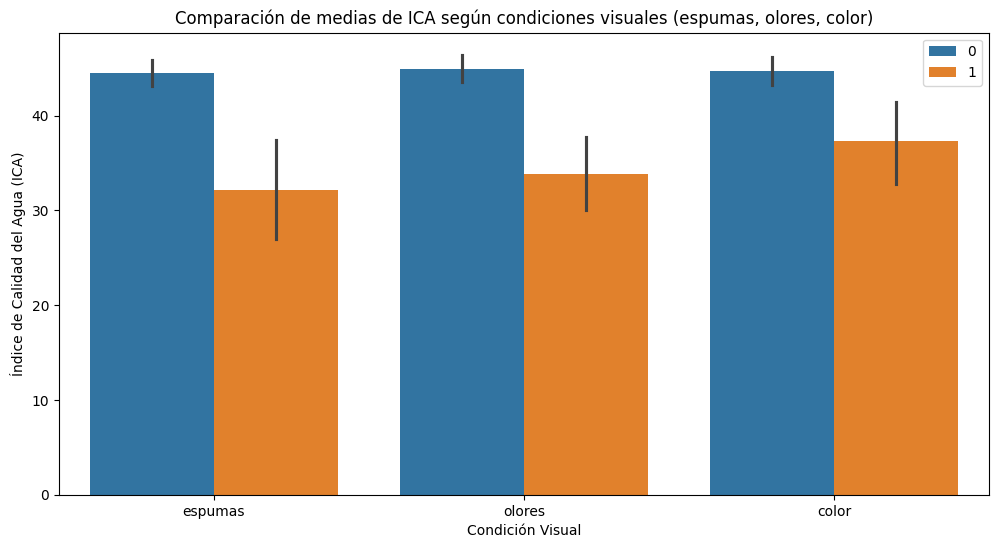

In [52]:
# Crear un gráfico de barras para comparar las medias de ICA según las condiciones visuales
plt.figure(figsize=(12, 6))

# Gráfico para comparar las medias de ICA según espumas, olores y color
sns.barplot(x='variable', y='ica', hue='valor', 
            data=pd.melt(copy_dataset[['ica', 'espumas', 'olores', 'color']],
             id_vars=['ica'], value_vars=['espumas', 'olores', 'color'], var_name='variable', value_name='valor'))

plt.title("Comparación de medias de ICA según condiciones visuales (espumas, olores, color)")
plt.ylabel("Índice de Calidad del Agua (ICA)")
plt.xlabel("Condición Visual")
plt.legend()
plt.show()

EN 0 SERIA LA MEDIA DE "ICA" SIN LA PRESENCIA DE ESAS VARIABLES EN LA MUESTRA.

EN 1 SERIA LA MEDIA DE "ICA" CON LA PRESENCIA DE ESAS VARIABLES EN LA MUESTRA

VEMOS QUE LA MAS CAMBIANTE ES CON O SIN ESPUMA.

C:\Users\Matias\AppData\Local\Temp\ipykernel_12584\1027988986.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


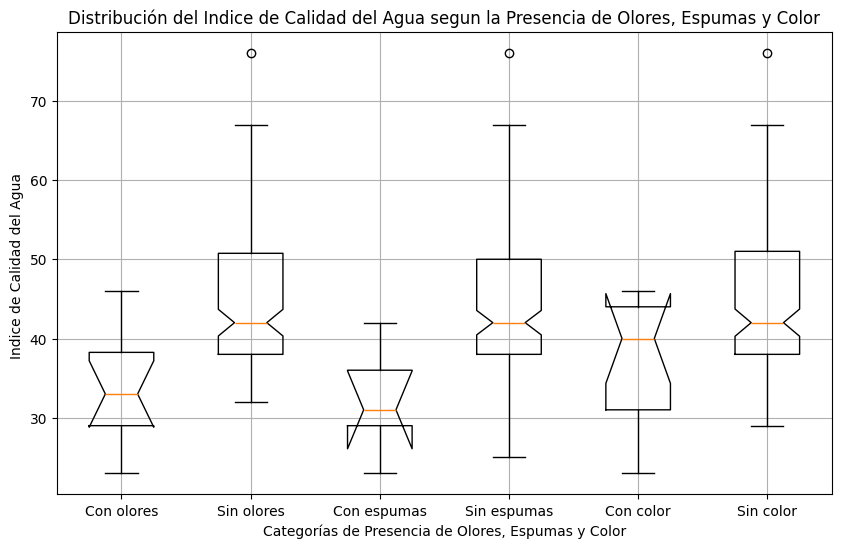

In [54]:
plt.figure(figsize=(10,6))
plt.boxplot([
    copy_dataset[copy_dataset["olores"] == 1.0]["ica"],
    copy_dataset[copy_dataset["olores"] == 0]["ica"],
    copy_dataset[copy_dataset["espumas"] == 1.0]["ica"],
    copy_dataset[copy_dataset["espumas"] == 0]["ica"],
    copy_dataset[copy_dataset["color"] == 1.0]["ica"],
    copy_dataset[copy_dataset["color"] == 0]["ica"]
    ],labels=["Con olores", "Sin olores","Con espumas", "Sin espumas","Con color", "Sin color"],notch=True)

plt.xlabel("Categorías de Presencia de Olores, Espumas y Color")
plt.ylabel("Indice de Calidad del Agua ")
plt.title("Distribución del Indice de Calidad del Agua segun la Presencia de Olores, Espumas y Color")
plt.grid(True)
plt.show()

Vemos que la mediana (Q2) para con o sin color es casi la misma, por lo que no hay gran variacion entre esos 2 factores, a simple vista pareciera no haber relacion

Como trabajamos con variables dicotomicas (olor, color, espuma) para confirmar que existe una relacion entre estas variables y la calidad del agua (que es categorica y se basa en 'niveles' de ICA), debemos de hacer una prueba de Chi cuadrado de independencia


In [55]:
from scipy.stats import chi2_contingency

# Crear una tabla de contingencia
contingency_table = pd.crosstab(index=[copy_dataset['olores'], copy_dataset['color'], copy_dataset['espumas']],
                                columns=copy_dataset['calidad_de_agua'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Imprimir resultados
print(f"Estadístico chi-cuadrado: {chi2}")
print(f"Valor p: {p}")
print(f"Grados de libertad: {dof}")

Estadístico chi-cuadrado: 7.672721417069243
Valor p: 0.6607702418385424
Grados de libertad: 10


Valor p: 𝑝=0.66
es mucho mayor que 0.05. Esto implica que no hay suficiente evidencia para rechazar la hipótesis nula de independencia. 
No se detecta una relación estadísticamente significativa entre las combinaciones de olor, color y espuma y los niveles de calidad

intentamos hacer un anova pero los resultados fueron los mismos, se rechaza la hipotesis

--------------------------------------------------------------------------------------------------------------------------------------------------------------

Veremos que pasa en OXIGENO DISUELTO, ya que su valor maximo es bastante alto en comparacion al resto

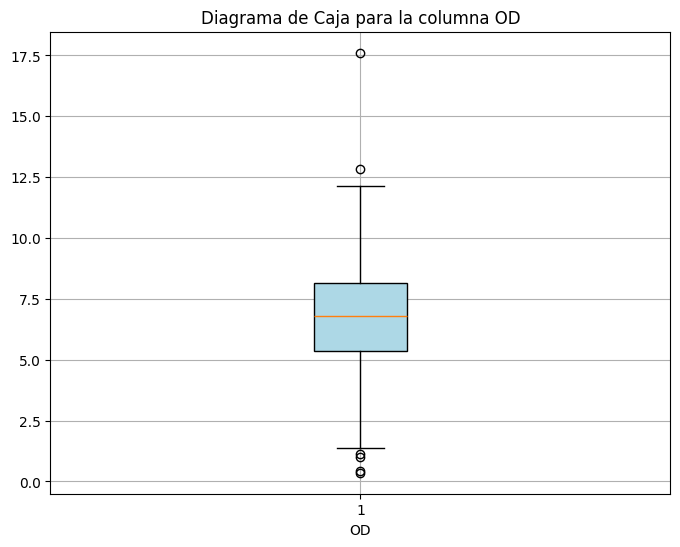

In [38]:
plt.figure(figsize=(8, 6))

# Creamos BOXPLOT
plt.boxplot(copy_dataset['od'].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))

plt.title('Diagrama de Caja para la columna OD')
plt.xlabel('OD')
plt.grid(True)

plt.show()

Despues de analizar este boxplot podemos encontrarnos con ciertos outliers, 2 por encima del limite superior y 4 por debajo del limite inferior. vemos que la mediana (Q2) es casi 7, que el Q1 y Q3 estan bastante cerca de de ese valor, lo que indicaria una distribucion bastante equilibrada entre los cuartiles. 
Sabemos que los valores optimos para "OD" oscilan entre 5 y 9. Veremos en que lugar se encuentra ese outlier en 17.5, ya que valores superiores a 10 mg/L son raros y, si aparecen, suelen deberse a procesos de fotosíntesis intensa en ciertas zonas, pero pueden estar acompañados de fluctuaciones.

In [39]:
copy_dataset[copy_dataset["od"] == 17.610]

,sitios,codigo,fecha,campaña,tem_agua,tem_aire,od,ph,olores,color,espumas,mat_susp,colif_fecales_ufc_100ml,escher_coli_ufc_100ml,enteroc_ufc_100ml,nitrato_mg_l,nh4_mg_l,p_total_l_mg_l,fosf_ortofos_mg_l,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua,tem_agua_norm,tem_aire_norm,ica_norm
73,Costanera Hudson Calle 63,BZ080,4/5/2022,otoño,17.000,17.000,17.610,9.980,0,0,0,0,20000.000,1000.000,800.000,6.200,0.050,0.520,0.430,18.000,59,60.000,0.100,0.007,0.001,10.000,0.150,40,3,0.514,0.565,0.321


El sitio se llama "costanera Hudson Calle 63", que ademas de niveles altisimos de Oxigeno Disuelto, presenta una alta contaminacion fecal, una moderada contaminacion por presencia de nitratos en el agua (influencia de actividades humanas, como la agricultura o las aguas residuales) y una turbiedad sumamente elevada, que podria estar influenciada directamente por el "OD"

Investigando un poco mas en los medios, vemos que Hudson esta marcado por una gran presencia de humedales los cuales ayudan a atrapar el carbono del aire, lo cual es muy importante para mitigar el cambio climatico y albergar biodiversidad. En consecuencia, el nivel de OD de 17 mg/L podría estar relacionado con un efecto de fotosíntesis intensa. Sin embargo, es ideal medir en diferentes momentos del día, ya que el oxígeno disuelto puede variar entre el día y la noche debido a la fotosíntesis y la respiración de los organismos acuáticos.

En conclusion, el outlier examinado podria no ser un error de medicion, en este caso, y si un claro ejemplo del impacto de los humedales

Los humedales pueden crear condiciones excepcionales para el aumento de oxígeno disuelto, esta justificación añade una capa importante de contexto ecológico a los datos, podriamos seguir explayando un poco mas a partir de esto

¿Hay una relacion directa entre los humedales y el oxigeno disuelto en las mediciones? ¿A que otros indicadores puede afectar la presencia de estos?

A este hecho sumarle los desastres causados por los megaemprendimientos y los incendios forestales en los humedales, repercurtiendo en otros indicadores como la turbiedad, el ph, la presencia de nitrato, etc.


filtraremos las 5 muestras con mayor "OXIGENO DISUELTO"

In [40]:
# Seleccionar las 5 filas con los valores más altos en la columna "OD"
top_5_od = copy_dataset.nlargest(5, 'od')

# Mostrar el resultado
print(top_5_od)

                        sitios codigo      fecha   campaña  tem_agua  tem_aire     od     ph  olores  color  espumas  mat_susp  colif_fecales_ufc_100ml  escher_coli_ufc_100ml  enteroc_ufc_100ml  nitrato_mg_l  nh4_mg_l  p_total_l_mg_l  fosf_ortofos_mg_l  dbo_mg_l  dqo_mg_l  turbiedad_ntu  hidr_deriv_petr_ug_l  cr_total_mg_l  cd_total_mg_l  clorofila_a_ug_l  microcistina_ug_l  ica  calidad_de_agua  tem_agua_norm  tem_aire_norm  ica_norm
73   Costanera Hudson Calle 63  BZ080   4/5/2022     otoño    17.000    17.000 17.610  9.980       0      0        0         0                20000.000               1000.000            800.000         6.200     0.050           0.520              0.430    18.000        59         60.000                 0.100          0.007          0.001            10.000              0.150   40                3          0.514          0.565     0.321
75           Camping Eva Perón  EN081   4/5/2022     otoño    13.600     8.000 12.840 10.020       0      0        0      

- Vemos que el ph en las 5 muestras oscila entre 8.3 y 10 lo que indicaria un leve a grave desequilibrio en el agua, producto de algun factor externo.
- Encontramos otra coincidencia. "Puerto Trinidad calle 47" y "Costanera Hudson calle 63" ambos estan en la localidad de Berazategui, y ambos lugares estan siendo victima de daños en los humedales desde hace unos años. La Concentración de nitratos en miligramos por litro (mg/L) en ambos lugares es bastante alta. El DBO y DQO son altisimos tambien.
- En "Puerto Trinidad calle 47" hay una marcada contaminacion fecal y alta presencia de formas de fósforo en el agua.

Vemos que el humano con sus inventos esta impactando severamente en la naturaleza de los humedales y su poder para manter el equilibrio y calidad del agua. Sumado a los incendios forestales desatados intencionalmente

Usaremos gráficos de dispersión (scatter plot) para analizar la relación entre el OD y las variables que sospechamos que pueden estar relacionadas, como PH, DBO, DQO o turbiedad.

metodo de normalizacion MIN-MAX

In [41]:
# normalizar las columnas 'OD','TURBIEDAD', 'ph', 'dbo' y 'dqo'. método de normalización min-max
copy_dataset['od_normalizado'] = (copy_dataset['od'] - copy_dataset['od'].min()) / (copy_dataset['od'].max() - copy_dataset['od'].min())
copy_dataset['turbiedad_normalizado'] = (copy_dataset['turbiedad_ntu'] - copy_dataset['turbiedad_ntu'].min()) / (copy_dataset['turbiedad_ntu'].max() - copy_dataset['turbiedad_ntu'].min())
copy_dataset['ph_normalizado'] = (copy_dataset['ph'] - copy_dataset['ph'].min()) / (copy_dataset['ph'].max() - copy_dataset['ph'].min())
copy_dataset['dbo_normalizado'] = (copy_dataset['dbo_mg_l'] - copy_dataset['dbo_mg_l'].min()) / (copy_dataset['dbo_mg_l'].max() - copy_dataset['dbo_mg_l'].min())
copy_dataset['dqo_normalizado'] = (copy_dataset['dqo_mg_l'] - copy_dataset['dqo_mg_l'].min()) / (copy_dataset['dqo_mg_l'].max() - copy_dataset['dqo_mg_l'].min())


Hacemos grafico de dispersion para "od y turbiedad"

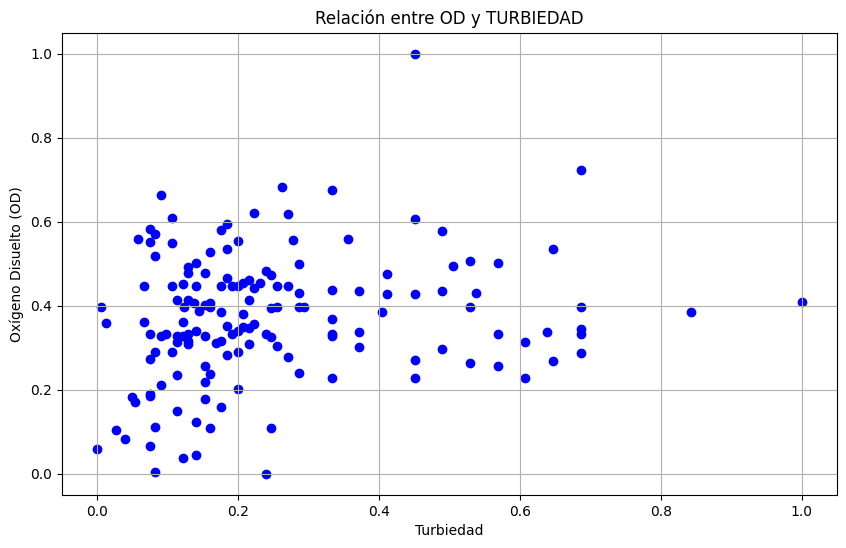

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(copy_dataset['turbiedad_normalizado'], copy_dataset['od_normalizado'], color='blue')
plt.xlabel('Turbiedad')
plt.ylabel('Oxígeno Disuelto (OD)')
plt.title('Relación entre OD y TURBIEDAD')
plt.grid(True)
plt.show()

In [43]:
# Calcular la correlación de Pearson entre las dos columnas
correlacion = copy_dataset['turbiedad_normalizado'].corr(copy_dataset['od_normalizado'])
print(f"Coeficiente de Correlación de Pearson: {correlacion}")

Coeficiente de Correlación de Pearson: 0.18515657596163507


OBSERVANDO EL GRAFICO Y USANDO EL COEFICIENTE DE PEARSON: Correlación muy débil o inexistente. Casi no hay relación lineal entre las variables "OD" y "turbiedad"

hacemos grafico de dispersion para "od y ph"

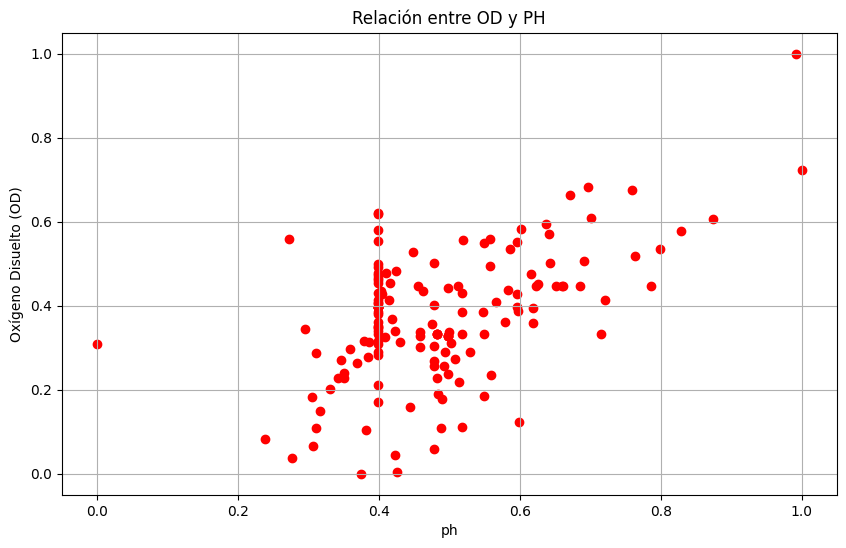

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(copy_dataset['ph_normalizado'], copy_dataset['od_normalizado'], color='red')
plt.xlabel('ph')
plt.ylabel('Oxígeno Disuelto (OD)')
plt.title('Relación entre OD y PH')
plt.grid(True)
plt.show()

In [45]:
# Calcular la correlación de Pearson entre las dos columnas
correlacion = copy_dataset['ph_normalizado'].corr(copy_dataset['od_normalizado'])
print(f"Coeficiente de Correlación de Pearson: {correlacion}")

Coeficiente de Correlación de Pearson: 0.5333541251594252


OBSERVANDO EL GRAFICO Y USANDO EL COEFICIENTE DE PEARSON: Correlación moderada. Existe una relación lineal clara, aunque no tan intensa entre las variables "OD" y "PH"

Hacemos grafico de dispersion entre "od y DBO"

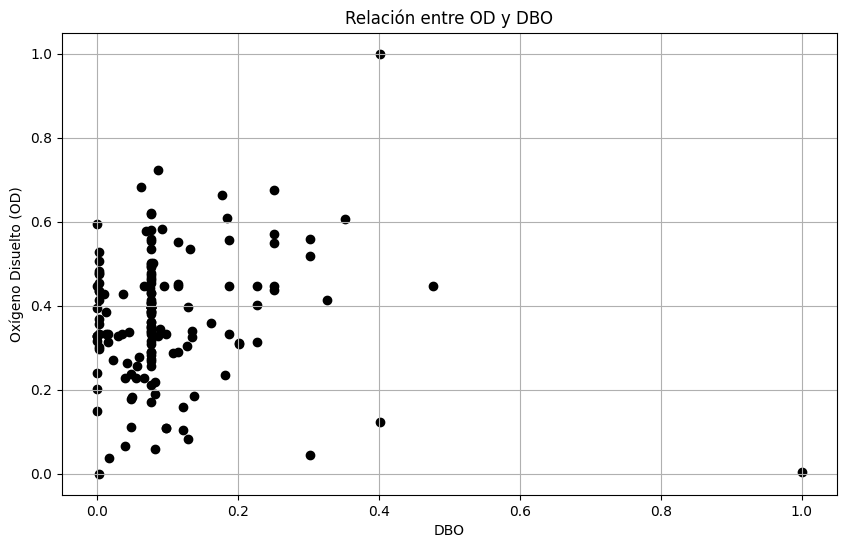

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(copy_dataset['dbo_normalizado'], copy_dataset['od_normalizado'], color='black')
plt.xlabel('DBO')
plt.ylabel('Oxígeno Disuelto (OD)')
plt.title('Relación entre OD y DBO')
plt.grid(True)
plt.show()

In [47]:
# Calcular la correlación de Pearson entre las dos columnas
correlacion = copy_dataset['dbo_normalizado'].corr(copy_dataset['od_normalizado'])
print(f"Coeficiente de Correlación de Pearson: {correlacion}")

Coeficiente de Correlación de Pearson: 0.0488570086506096


OBSERVANDO EL GRAFICO Y USANDO EL COEFICIENTE DE PEARSON: Correlación muy débil o inexistente. Casi no hay relación lineal entre las variables.

Hacemos grafico de dispersion entre "od y dqo"

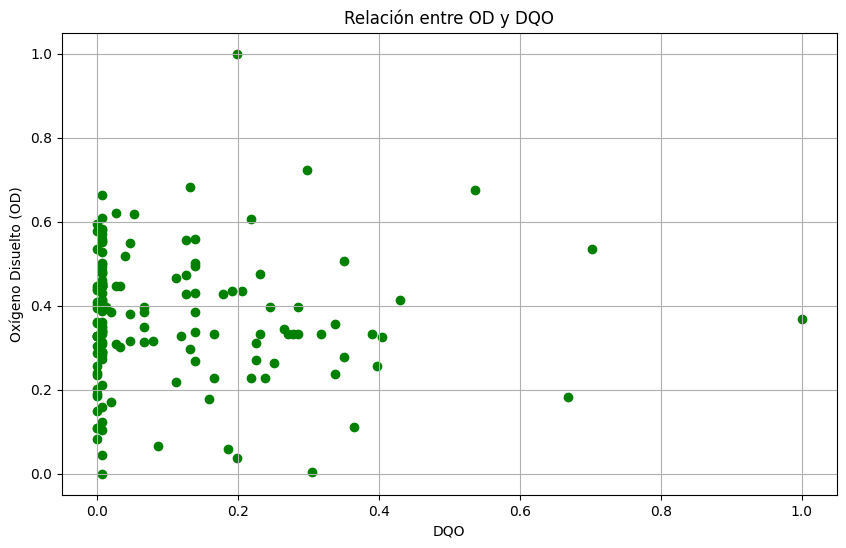

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(copy_dataset['dqo_normalizado'], copy_dataset['od_normalizado'], color='green')
plt.xlabel('DQO')
plt.ylabel('Oxígeno Disuelto (OD)')
plt.title('Relación entre OD y DQO')
plt.grid(True)
plt.show()

In [49]:
# Calcular la correlación de Pearson entre las dos columnas
correlacion = copy_dataset['dqo_normalizado'].corr(copy_dataset['od_normalizado'])
print(f"Coeficiente de Correlación de Pearson: {correlacion}")

Coeficiente de Correlación de Pearson: -0.018843923426437828


OBSERVANDO EL GRAFICO Y USANDO EL COEFICIENTE DE PEARSON: Correlación muy débil o inexistente. Casi no hay relación lineal entre las variables.

EN CONCLUSION, SOLAMENTE EXISTE UNA RELACION LINEAL CLARA ENTRE EL "OXIGENO DISUELTO Y EL PH", AUNQUE NO ES FUERTE Y PRECISA

sospechamos que la relación puede no ser lineal, intentemos ajustar un polinomio de segundo

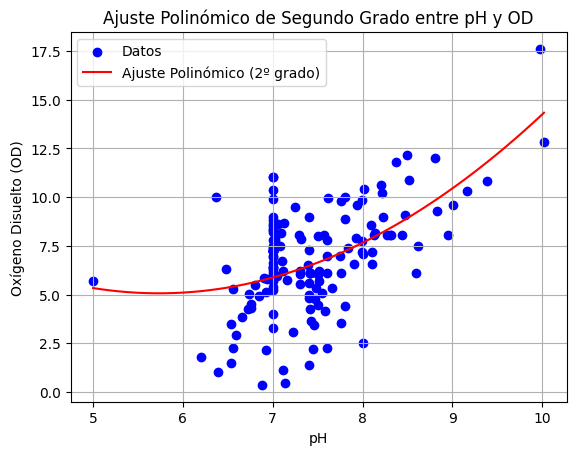

In [50]:
# Ajuste polinómico de segundo grado
coef = np.polyfit(copy_dataset['ph'], copy_dataset['od'], 2)  # 2 representa el grado del polinomio
poli1 = np.poly1d(coef)

# Generar valores ajustados
x_vals = np.linspace(copy_dataset['ph'].min(), copy_dataset['ph'].max(), 100)
y_vals = poli1(x_vals)

# Graficar
plt.scatter(copy_dataset['ph'], copy_dataset['od'], label='Datos', color='blue')
plt.plot(x_vals, y_vals, label='Ajuste Polinómico (2º grado)', color='red')
plt.xlabel('pH')
plt.ylabel('Oxígeno Disuelto (OD)')
plt.title('Ajuste Polinómico de Segundo Grado entre pH y OD')
plt.grid(True)
plt.legend()
plt.show()

In [51]:
# Ajuste polinómico de segundo grado
coef2 = np.polyfit(copy_dataset['ph'], copy_dataset['od'], 2)
poli2 = np.poly1d(coef2)
y_pred2 = poli2(copy_dataset['ph'])

# Ajuste polinómico de tercer grado
coef3 = np.polyfit(copy_dataset['ph'], copy_dataset['od'], 3)
poli3 = np.poly1d(coef3)
y_pred3 = poli3(copy_dataset['ph'])

# Calcular el MSE para ambos ajustes
mse_2nd_degree = mean_squared_error(copy_dataset['od'], y_pred2)
mse_3rd_degree = mean_squared_error(copy_dataset['od'], y_pred3)

print(f"MSE Ajuste Polinómico (2º grado): {mse_2nd_degree}")
print(f"MSE Ajuste Polinómico (3º grado): {mse_3rd_degree}")

MSE Ajuste Polinómico (2º grado): 4.751363127627031
MSE Ajuste Polinómico (3º grado): 4.7433748693293705


Dado que la diferencia es pequeña, se podría optar por el modelo de segundo grado, que es más simple y evita posibles problemas de sobreajuste (overfitting).

---------------------------------------------------------------------------------------------------------------------------------------------------------------

Vimos que el DBO_MG_L era la demanda biológica de oxígeno en miligramos por litro (mg/L), que mide la cantidad de oxígeno requerido por microorganismos para descomponer materia orgánica, y que en valores bastante altos, el agua podria estar recibiendo grandes cantidades de materia orgánica, posiblemente debido a descargas de aguas residuales, desechos industriales o actividad agrícola.

veremos con que variable podria estar potencialmente relacionada

antes que nada borrar viejas columnas creadas para normalizar

In [57]:
copy_dataset = copy_dataset.drop(['dbo_normalizado', 'ph_normalizado', 'od_normalizado','dqo_normalizado','tem_agua_norm','tem_aire_norm','turbiedad_normalizado','ica_norm'], axis=1)

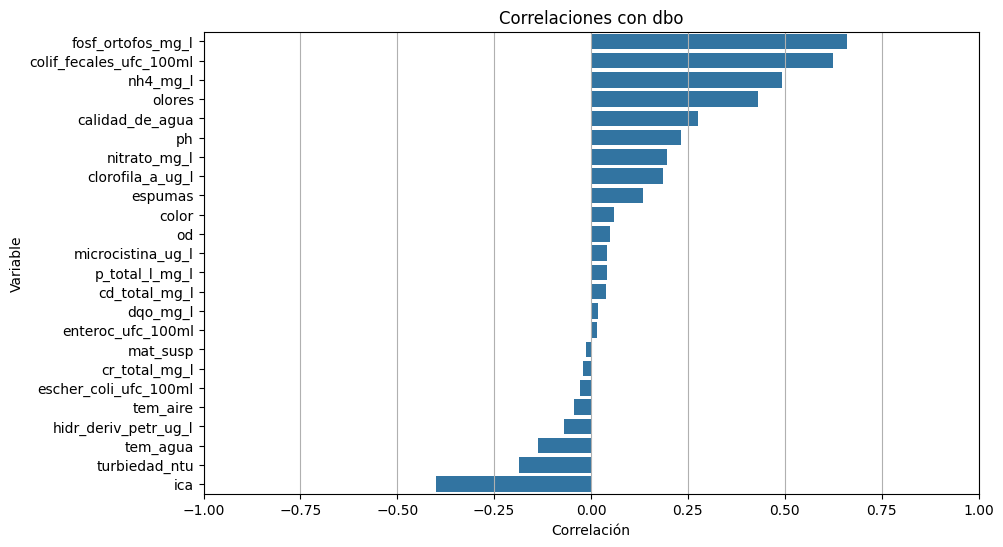

In [58]:
dbo_correlation = copy_dataset.corr(numeric_only=True)["dbo_mg_l"].drop("dbo_mg_l")
sorted_correlations = dbo_correlation.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.grid(True)
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index)
plt.title('Correlaciones con dbo')
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.xlim([-1, 1])
plt.show()

Vemos que se tiene una correlacion bastante alta con fosfo_ortofos, entonces vamos a ver que sucede ahi

Posible Hipotesis:
"A mayor concentración de fósforo ortofosfato (fosf_ortofos_mg_l), mayor será la demanda biológica de oxígeno (DBO, mg/L) en el agua."


Para empezar tenemos dos variables continuas entonces voy a verificar si ambas variables son normales y homocedasticas para realizar un test-t

In [60]:
from scipy.stats import shapiro

dbo_dataset = copy_dataset["dbo_mg_l"]
fosf_dataset = copy_dataset["fosf_ortofos_mg_l"]

stat,p = shapiro(dbo_dataset)
print(f"Test de Shapiro-Wilk para la variable dbo: Estadístico={stat:.3f}, p-valor={p:.3f}")

stat,p = shapiro(fosf_dataset)
print(f"Test de Shapiro-Wilk para la variable fosf: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para la variable dbo: Estadístico=0.655, p-valor=0.000
Test de Shapiro-Wilk para la variable fosf: Estadístico=0.725, p-valor=0.000


El test de Shapiro-Wilk nos dice que ninguna de las dos variables sigue una distribucion normal

Por lo tantos haremos pruebas no parametricas,pero para ello veremos si tienen homocedasticidad primero


In [61]:
from scipy.stats import levene

stat, p = levene(dbo_correlation, fosf_dataset)
print(f"Test de Levene para la Homocedasticidad: Estadístico={stat:.3f}, p-valor={p:.3f}")


Test de Levene para la Homocedasticidad: Estadístico=0.045, p-valor=0.832


Vemos que son homocedasticas, por lo tanto ya probamos que las variables no son normales y vimos que su distribucion es homocedasticas entonces podemos utilizar un test de Spearman

In [62]:
from scipy.stats import spearmanr

# Calcular la correlación de Spearman
correlacion, p_valor = spearmanr(copy_dataset["dbo_mg_l"], copy_dataset["fosf_ortofos_mg_l"])

# Imprimir los resultados
print(f"Coeficiente de correlación de Spearman: {correlacion:.4f}")
print(f"P-valor: {p_valor:.4f}")

# Interpretación del p-valor
if p_valor < 0.05:
    print("La correlación es significativa.")
else:
    print("No hay evidencia suficiente para afirmar que la correlación es significativa.")

Coeficiente de correlación de Spearman: 0.4130
P-valor: 0.0000
La correlación es significativa.


El análisis de correlación de Spearman realizado entre las variables dbo_mg_l y fosf_ortofos_mg_l arrojó un coeficiente de 0.4130 indicando una correlación positiva moderada entre ambas. Además, el p-valor obtenido fue 0.0000, lo que confirma que esta correlación es estadísticamente significativa (p < 0.05). Por lo tanto, se puede concluir que existe una relación significativa entre las concentraciones de DBO y fosfatos ortofosfatos en el dataset.#Elegir entre esta conclusion o la de abajo

Como vemos nuestro p-valor es menos que nuestro nivel de significancia(0.5) entonces rechazamos nuestra hipotesis nula y vemos que la concentracion de fosforo ortofosfato no implica una mayor demanda de biologica de oxigeno

-----------------------------------------------------------------------------------------------------------------------------------------------------------